In [1]:
import torch
from tqdm.auto import tqdm
from torch.optim import AdamW
from transformers import get_scheduler
from optree import tree_map_
import pickle
import matplotlib.pyplot as plt

import uqlib

from load import load_dataloaders, load_model

In [2]:
# Load data
train_dataloader, eval_dataloader = load_dataloaders(small=True)
num_data = len(train_dataloader.dataset)

In [3]:
# Load model (with standard Gaussian prior)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model, param_to_log_posterior = load_model(
    num_data=num_data, device=device, trained_prior_sd=1e5, untrained_prior_sd=1e5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# Train (as usual, using native PyTorch) for MAP
optimizer = AdamW(model.parameters(), lr=5e-5, maximize=True)

num_epochs = 4
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)


progress_bar = tqdm(range(num_training_steps))

log_posts = []

# model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}

        log_post = param_to_log_posterior(dict(model.named_parameters()), batch)

        log_post.backward()
        log_posts.append(log_post.item())
        
        print(log_posts[-1], end='\r')

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/500 [00:00<?, ?it/s]

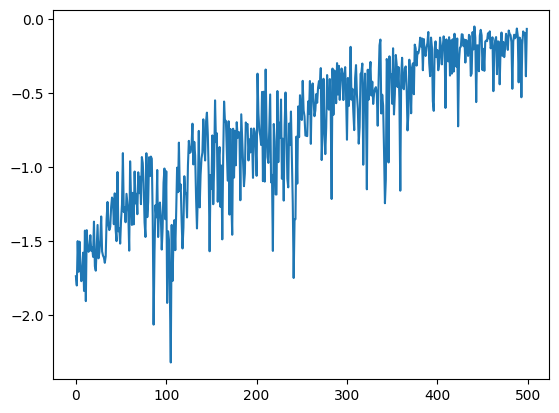

In [5]:
plt.plot(log_posts);

In [6]:
# Use uqlib for diagonal Fisher information covariance matrix
progress_bar_2 = tqdm(range(len(train_dataloader)))

laplace_state = uqlib.laplace.diag_fisher.init(dict(model.named_parameters()))

for batch in train_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    laplace_state = uqlib.laplace.diag_fisher.update(
        laplace_state, param_to_log_posterior, batch
    )
    progress_bar_2.update(1)

  0%|          | 0/125 [00:00<?, ?it/s]

In [7]:
# Save state
laplace_state = tree_map_(lambda x: x.detach().cpu(), laplace_state)
pickle.dump(laplace_state, open("yelp_laplace_state.pkl", "wb"))

# laplace_state = pickle.load(open("yelp_laplace_state.pkl", "rb"))

In [8]:
# # Alternatively we could get the diagonal Hessian for the precision matrix
# progress_bar_2 = tqdm(range(len(train_dataloader)))

# laplace_state = uqlib.laplace.diag_hessian.init(dict(model.named_parameters()))

# for batch in train_dataloader:
#     batch = {k: v.to(device) for k, v in batch.items()}
#     laplace_state = uqlib.laplace.diag_hessian.update(
#         laplace_state, param_to_log_posterior, batch
#     )
#     progress_bar_2.update(1)

In [9]:
laplace_state.prec_diag

{'bert.embeddings.word_embeddings.weight': tensor([[4.6142e-38, 2.7201e-34, 2.8228e-35,  ..., 2.3816e-36, 1.8900e-34,
          3.8105e-35],
         [4.7250e-35, 1.5242e-34, 2.9531e-36,  ..., 3.8105e-35, 2.0656e-34,
          2.1317e-36],
         [5.5511e-38, 1.1291e-34, 1.1813e-35,  ..., 1.5574e-35, 1.8900e-34,
          4.7250e-35],
         ...,
         [6.6028e-36, 4.7250e-35, 6.8001e-35,  ..., 2.7201e-34, 3.9730e-34,
          2.9531e-36],
         [3.5527e-36, 1.0625e-36, 1.3643e-34,  ..., 4.2258e-34, 3.2275e-36,
          2.3102e-35],
         [1.8900e-34, 1.5242e-34, 7.9316e-35,  ..., 3.6202e-35, 4.5164e-34,
          1.2830e-34]], device='cuda:0'),
 'bert.embeddings.position_embeddings.weight': tensor([[1.6590e-02, 2.6294e-02, 5.2931e-02,  ..., 2.6461e-02, 2.6251e-02,
          2.6256e-02],
         [8.5779e-02, 1.0039e-01, 9.7364e-02,  ..., 3.4994e-02, 6.9636e-02,
          3.9280e-02],
         [3.8099e-02, 1.0806e-01, 3.9837e-02,  ..., 5.4445e-02, 5.3142e-02,
          4

In [10]:
prec_diag = torch.cat([v.detach().cpu().flatten() for v in laplace_state.prec_diag.values()]).numpy()

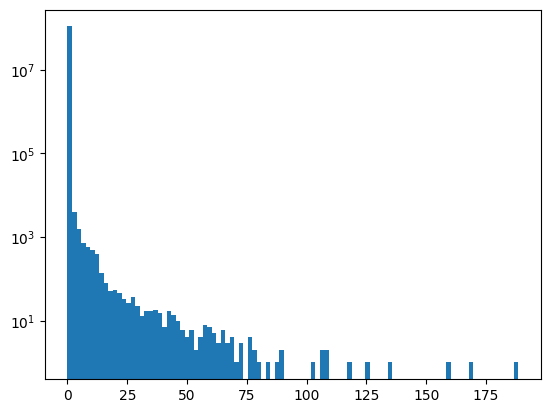

In [14]:
plt.hist(prec_diag, bins=100, log=True);